# Visualization of SSE model results
### D. Li, 27.1.2021

In [1]:
# initialize and load modules
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import pyproj
import scipy.io as sio
from scipy import spatial
from cmcrameri import cm
from scipy.io import netcdf_file as netcdf

import matplotlib 
matplotlib.rc('xtick', labelsize=9) 
matplotlib.rc('ytick', labelsize=9)

print('module loaded')

module loaded


In [2]:
# Load accumulative SSE slip
folder = '/import/deadlock-data/dli/Mexico/TriSSE/model_coarse/'
tfile = np.loadtxt(folder+ 'lk20_h90_N25_T2_slip/t_sse-lk20_h90_N25_T2.dat');
lnum = 4000;
t_sse = tfile[0:lnum-1];

## % slp1
pp = [1, 144]; # ep1
pp = [145, 231];
pp = [232, 371];
pp = [372, 432];
pp = [433, 558];
pp = [559, 728]; #ep6
pp = [729, 881]; #ep7

# load geographic symbols
depcon = np.loadtxt(folder + './Contour/contour_latlon2.txt');
eq = np.loadtxt(folder + './Contour/2014Eq_USGS.txt');
af = np.loadtxt(folder + './Contour/2014Eq_aftershock.txt');
city = np.loadtxt(folder + './Contour/city2.txt');
trch = np.loadtxt(folder + './Contour/MAT_trench.txt');
coslp = netcdf(folder + '../Gaulandi/coslp2.grd','r').variables['z'][::1];
cox = netcdf(folder + '../Gaulandi/coslp2.grd','r').variables['lon'][::1];
coy = netcdf(folder + '../Gaulandi/coslp2.grd','r').variables['lat'][::1];
X,Y = np.meshgrid(cox,coy)

coastf = '/import/deadlock-data/dli/Mexico/TriSSE/model_coarse/Contour/guerrero.mat'
coast = sio.loadmat(coastf)

accslip = np.loadtxt(folder + 'lk20_h90_N25_T2_slip/slp_ep6_yr22.txt')
cfs = np.loadtxt('/import/schreck-data/dli/Mexico/Launch_Seissol/Coulomb/cfs_ep6.txt')

#%% calculate accumulative slip on the fault
data = np.loadtxt(folder + 'stiffness4/triangular_mesh.gts')
nvex = int(data[0,0])
ncell = int(data[0,2])
print(nvex,ncell)

vertex = data[1:nvex+1,:]/1e3
connect =  data[1+nvex:nvex+ncell+1,:]-1

miu = 30e+9;
coeff = 1e+6;
vpl = 41/1000/365/24/3600;
yrs = 365*24*3600 ;

print(vertex.shape)
print(connect.shape)

# plt.figure()
# plt.contour(X,Y,coslp,levels=12,colors='k')
# plt.show()

/home/dli/anaconda3/lib/python3.8/site-packages/scipy/io/netcdf.py:308: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  warnings.warn((


45737 90496
(45737, 3)
(90496, 3)


In [3]:
# set projection
myproj = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')
lla = pyproj.Proj(proj='utm',zone='11N',ellps='WGS84', datum='WGS84')

trench = np.loadtxt('/import/deadlock-data/dli/Mexico/Launch_SeisSol/trench.txt')
epi = np.loadtxt('/import/schreck-data/dli/Mexico/Launch_Seissol/smallslab/2014EQ/2014Eq_USGS.txt')
aft = np.loadtxt('/import/schreck-data/dli/Mexico/Launch_Seissol/smallslab/2014EQ/2014Eq_aftershock.txt')

# transform coordinates
refer =  [2211956.564907321, 2065452.360267957]
xx = vertex[:,0]*1e3 
yy = vertex[:,1]*1e3

theta = -55/180*np.pi

x1 = np.cos(theta)*xx + np.sin(theta)*yy;
y1 = -np.sin(theta)*xx + np.cos(theta)*yy;

x2 = x1+refer[0]
y2 = y1+refer[1]

coords = pyproj.transform(lla, myproj, x2,y2, x2-x2, radians=False)

xr = coords[0]
yr = coords[1]

triang = tri.Triangulation(xr,yr,connect)

ct = np.max(100*accslip)*0.2
print(ct)

aa = np.where(accslip>ct/100,accslip,0.0)

bb = np.array([xr,yr])
print(bb)

# print(npoint)

4.5589376
[[ -99.82184988 -103.2495739   -99.84595963 ...  -99.9380811
   -99.96651345  -99.95540361]
 [  16.42689757   18.0818423    16.43827323 ...   17.65515704
    17.66326637   17.66777122]]


<ipython-input-3-ec696d4a0fb3>:22: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  coords = pyproj.transform(lla, myproj, x2,y2, x2-x2, radians=False)


<IPython.core.display.Javascript object>


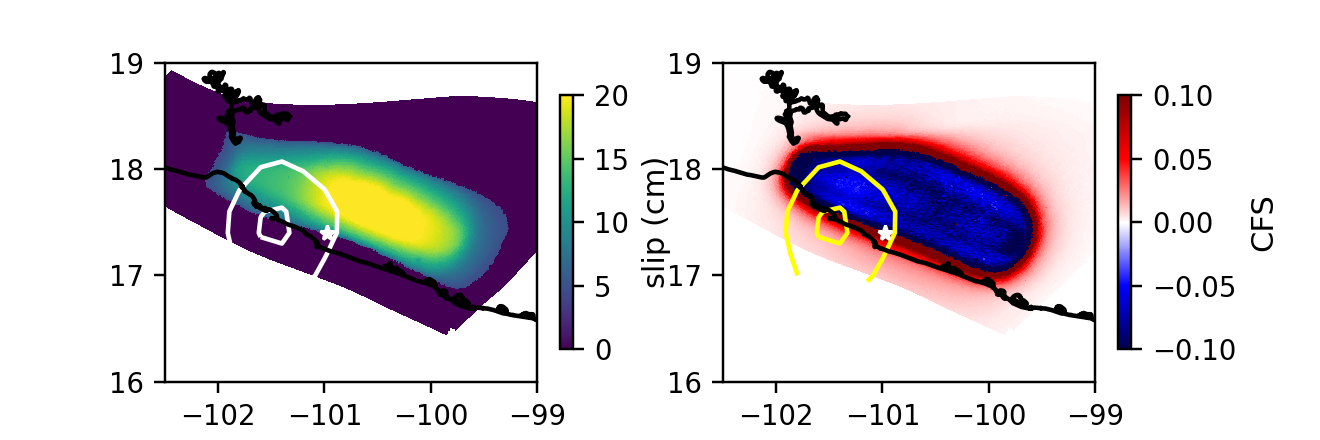

In [73]:
fig,([ax1,ax0]) = plt.subplots(nrows=1,ncols=2,figsize=(6,2))

sc = ax1.tripcolor(triang,100*aa, cmap='viridis',shading='flat',vmin=0,vmax=20)
cl = fig.colorbar(sc,ax=ax1,shrink=0.75)
cl.set_label('slip (cm)')

ax1.set(xlim=(-102.5, -99),ylim=(16,19))
ax1.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
ax1.plot(epi[0,0],epi[0,1],'*w',markersize=5)
ax1.contour(X,Y,coslp,levels=[8,16],colors='w')
ax1.set_aspect(1)

sc = ax0.tripcolor(triang,-cfs,cmap='seismic',shading='flat',vmin=-0.1,vmax=0.1)
cl = fig.colorbar(sc,ax=ax0,shrink=0.75)
cl.set_label('CFS')

ax0.set(xlim=(-102.5, -99),ylim=(16,19))
ax0.plot(epi[0,0],epi[0,1],'*w',markersize=5)
ax0.contour(X,Y,coslp,levels=[8,16],colors='yellow')
ax0.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
ax0.set_aspect(1)

plt.show()
outname = 'CFS-slp-yr21.png'
plt.savefig(outname,dpi=100,transparent=False)
np.savetxt('slp_ep6_yr22_cut.txt',aa,fmt='%12.5e')

In [7]:
folder = '/import/deadlock-data/dli/Mexico/TriSSE/model_coarse/'
tfile = np.loadtxt(folder+ 'lk20_h90_N25_T2_slip/t_sse-lk20_h90_N25_T2.dat');
tfile2= np.loadtxt(folder+ 'lk20_h90_N25_T2/t_sse-lk20_h90_N25_T2.dat');

# lnum = 881;
ncell = 90496

sfilename = folder + 'lk20_h90_N25_T2/slipz1_tau2.bin'
sfile = open(sfilename,mode='rb')
sfilecont = np.fromfile(sfile,dtype='<f4')
sfile.close()

filename = folder + 'lk20_h90_N25_T2/slipz1_sse2.bin'
file = open(filename, mode='rb')# b is important -> binary
filecontent = np.fromfile(file,dtype='<f4')
file.close()

filename = folder + 'lk20_h90_N25_T2_slip/slipz1_slp1.bin'
file = open(filename, mode='rb')# b is important -> binary
fileslip = np.fromfile(file,dtype='<f4')
file.close()

<IPython.core.display.Javascript object>


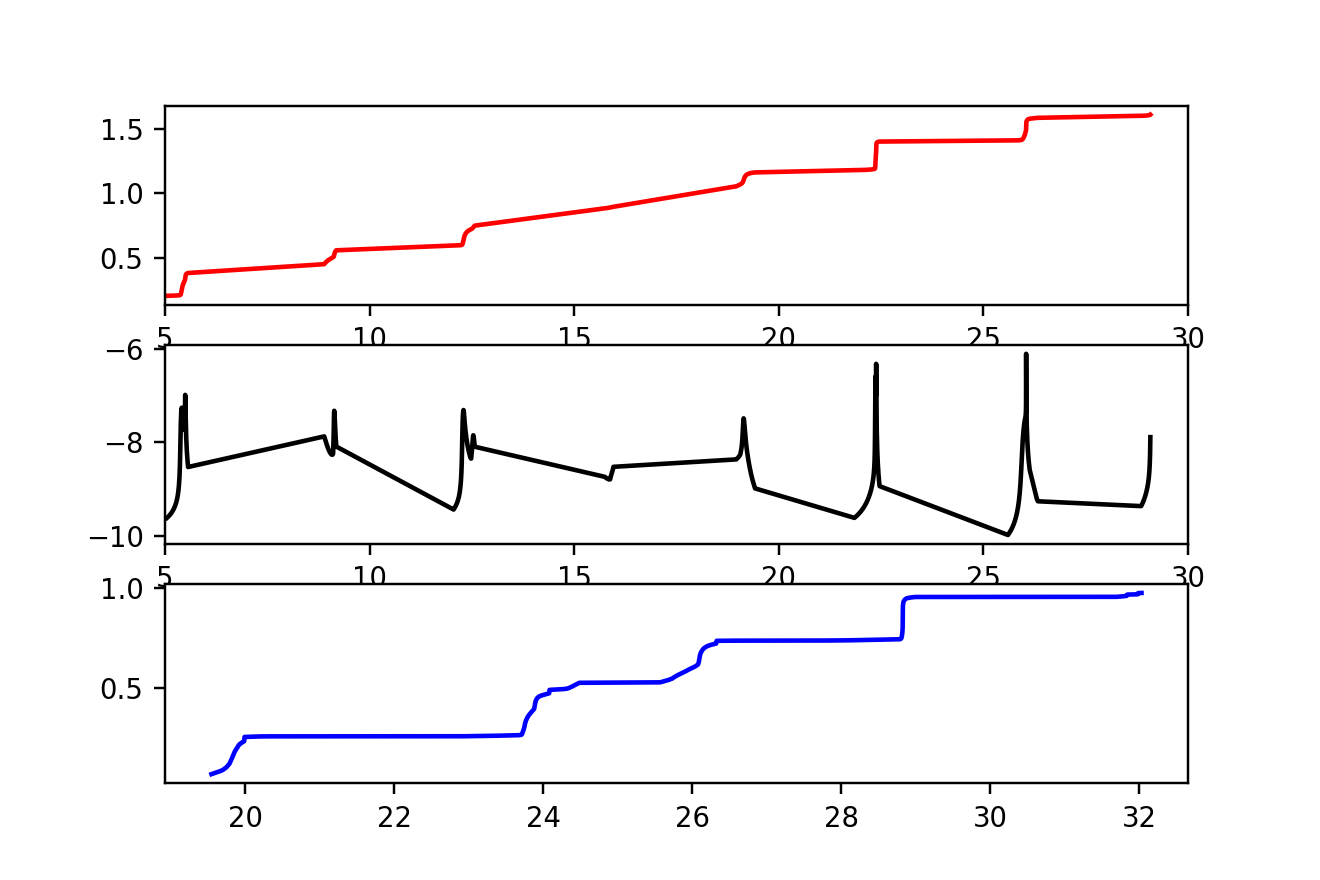

In [44]:
## plot slip rate vs. time

p1 = np.loadtxt(folder + 'lk20_h90_N25_T2/maxv_all-lk20_h90_N25_T2.dat')
pp = np.array([646, 10576, 13512, 10602, 6310, 6345, 623, 4041])

n0 = pp[0]
nn = len(tfile)
slp0 = fileslip[0:ncell*nn]
sl = slp0[n0::ncell]

sr0 = filecontent[0:ncell*nn]
sr = sr0[n0::ncell]

n0 = pp[0]
nn = 1000
tau0 = sfilecont[0:ncell*nn]
tau = tau0[n0::ncell]

fig,([ax0,ax1,ax2]) = plt.subplots(nrows=3,ncols=1,figsize=(6,4))
ax0.plot(tfile,sl,'-r')
ax1.plot(tfile,sr,'-k' )
# ax1.plot(p1[:,0],p1[:,1],'-k')
ax2.plot(tfile2[1000:2000],tau,'-b')

# ax2.set_xlim(30,50)
ax1.set_xlim(5,30)
ax0.set_xlim(5,30)


plt.show()

<IPython.core.display.Javascript object>


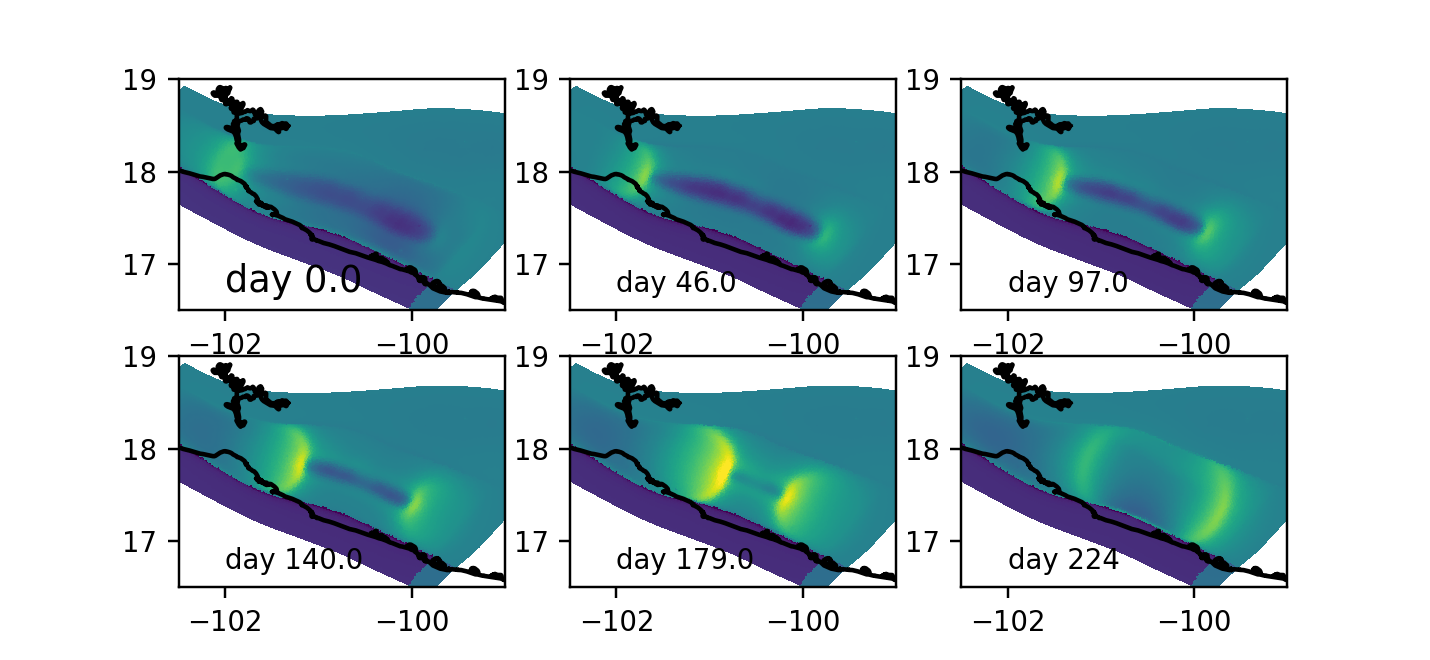

In [8]:
## slip rate
pp = [580, 590, 600, 610, 620, 645]; # year 10
pp = [647, 700, 760, 820, 880, 966]; # year 14
pp = np.array([559, 559+33, 559+66, 559+99, 559+132, 559+165]);
pp = pp-1;

yrs = 365
dt = tfile[pp] - tfile[pp[0]]
dt = dt*yrs 
# duration = (tfile[pp[-1]] - tfile[pp[0]])*365 ;

vcos = np.zeros((6,ncell))
stress=np.zeros((6,ncell))

for i in range(0,6):
    jj = pp[i]
    vcos[i,:] = 0.5*filecontent[jj*ncell-ncell:jj*ncell]+ 0.5*filecontent[jj*ncell:jj*ncell+ncell]
    stress[i,:]=0.5*sfilecont[jj*ncell-ncell:jj*ncell]+ 0.5*sfilecont[jj*ncell:jj*ncell+ncell]
    
fig,([ax0,ax1,ax2],[ax3,ax4,ax5]) = plt.subplots(nrows=2,ncols=3,figsize=(6.5,3))
    
sc = ax0.tripcolor(triang,vcos[0,:], cmap='viridis',shading='flat',vmin=-10,vmax=-7)
# cl = fig.colorbar(sc,ax=ax0,shrink=0.75)
ax0.set(xlim=(-102.5, -99),ylim=(16.5,19))
ax0.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
ax0.text(-102, 16.7, 'day '+str(np.floor(dt[0])),fontsize=12);

sc = ax1.tripcolor(triang,vcos[1,:], cmap='viridis',shading='flat',vmin=-10,vmax=-7)
# cl = fig.colorbar(sc,ax=ax1,shrink=0.75)
ax1.set(xlim=(-102.5, -99),ylim=(16.5,19))
ax1.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
ax1.text(-102, 16.7, 'day '+str(np.floor(dt[1])),fontsize=9);

sc = ax2.tripcolor(triang,vcos[2,:], cmap='viridis',shading='flat',vmin=-10,vmax=-7)
# cl = fig.colorbar(sc,ax=ax1,shrink=0.75)
ax2.set(xlim=(-102.5, -99),ylim=(16.5,19))
ax2.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
ax2.text(-102, 16.7, 'day '+str(np.floor(dt[2])),fontsize=9);

sc = ax3.tripcolor(triang,vcos[3,:], cmap='viridis',shading='flat',vmin=-10,vmax=-7)
# cl = fig.colorbar(sc,ax=ax1,shrink=0.75)
ax3.set(xlim=(-102.5, -99),ylim=(16.5,19))
ax3.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
ax3.text(-102, 16.7, 'day '+str(np.floor(dt[3])),fontsize=9);

sc = ax4.tripcolor(triang,vcos[4,:], cmap='viridis',shading='flat',vmin=-10,vmax=-7)
# cl = fig.colorbar(sc,ax=ax1,shrink=0.75)
ax4.set(xlim=(-102.5, -99),ylim=(16.5,19))
ax4.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
ax4.text(-102, 16.7, 'day '+str(np.floor(dt[4])),fontsize=9);

sc = ax5.tripcolor(triang,vcos[5,:], cmap='viridis',shading='flat',vmin=-10,vmax=-7)
# cl = fig.colorbar(sc,ax=ax1,shrink=0.75)
ax5.set(xlim=(-102.5, -99),ylim=(16.5,19))
ax5.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
# ax5.text(-102, 16.7, 'day '+str(np.floor(dt[5])),fontsize=9)
ax5.text(-102, 16.7, 'day '+str(224),fontsize=9)


plt.show()
outname = 'snapshot_sr.png'
plt.savefig(outname,dpi=150,transparent=False)

<IPython.core.display.Javascript object>


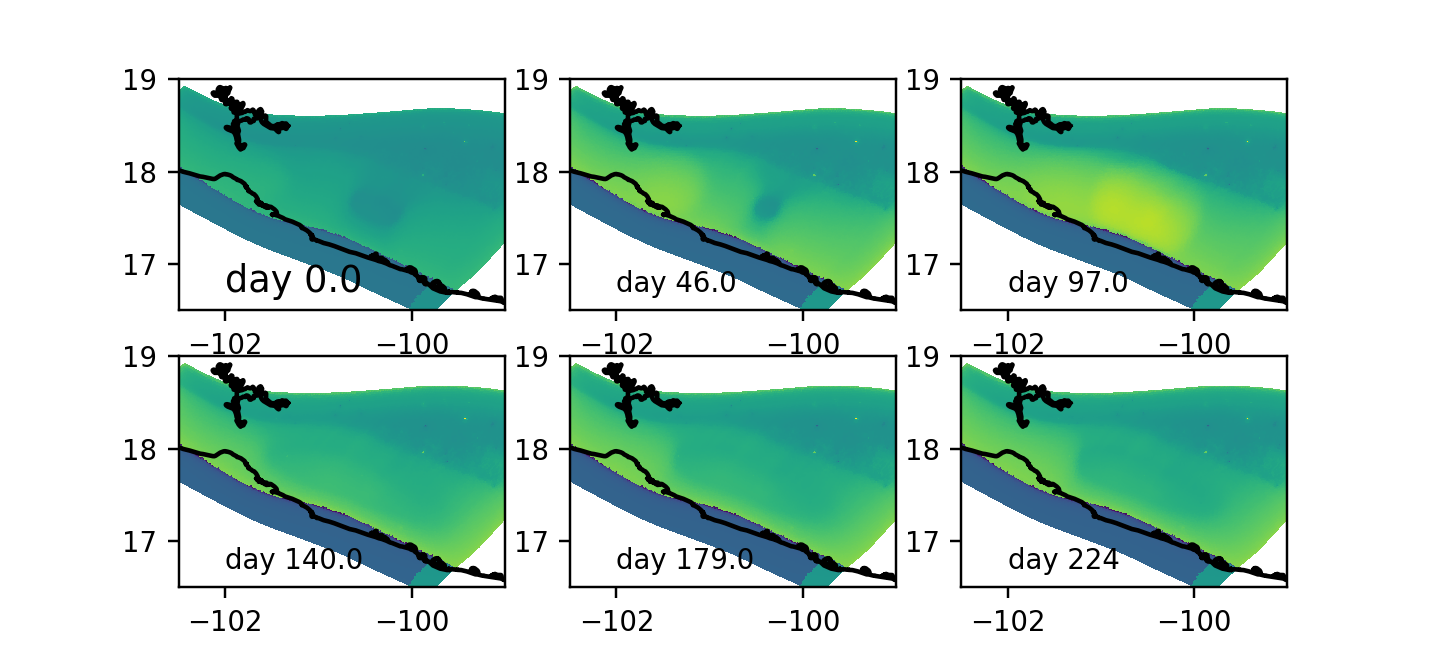

In [14]:
fig,([ax0,ax1,ax2],[ax3,ax4,ax5]) = plt.subplots(nrows=2,ncols=3,figsize=(6.5,3))
    
sc = ax0.tripcolor(triang,stress[0,:], cmap='viridis',shading='flat',vmin=0,vmax=1)
# cl = fig.colorbar(sc,ax=ax0,shrink=0.75)
ax0.set(xlim=(-102.5, -99),ylim=(16.5,19))
ax0.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
ax0.text(-102, 16.7, 'day '+str(np.floor(dt[0])),fontsize=12);

sc = ax1.tripcolor(triang,stress[1,:], cmap='viridis',shading='flat')
# cl = fig.colorbar(sc,ax=ax1,shrink=0.75)
ax1.set(xlim=(-102.5, -99),ylim=(16.5,19))
ax1.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
ax1.text(-102, 16.7, 'day '+str(np.floor(dt[1])),fontsize=9);

sc = ax2.tripcolor(triang,stress[2,:], cmap='viridis',shading='flat')
# cl = fig.colorbar(sc,ax=ax1,shrink=0.75)
ax2.set(xlim=(-102.5, -99),ylim=(16.5,19))
ax2.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
ax2.text(-102, 16.7, 'day '+str(np.floor(dt[2])),fontsize=9);

sc = ax3.tripcolor(triang,stress[3,:], cmap='viridis',shading='flat')
# cl = fig.colorbar(sc,ax=ax1,shrink=0.75)
ax3.set(xlim=(-102.5, -99),ylim=(16.5,19))
ax3.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
ax3.text(-102, 16.7, 'day '+str(np.floor(dt[3])),fontsize=9);

sc = ax4.tripcolor(triang,stress[4,:], cmap='viridis',shading='flat')
# cl = fig.colorbar(sc,ax=ax1,shrink=0.75)
ax4.set(xlim=(-102.5, -99),ylim=(16.5,19))
ax4.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
ax4.text(-102, 16.7, 'day '+str(np.floor(dt[4])),fontsize=9);

sc = ax5.tripcolor(triang,stress[5,:], cmap='viridis',shading='flat')
# cl = fig.colorbar(sc,ax=ax1,shrink=0.75)
ax5.set(xlim=(-102.5, -99),ylim=(16.5,19))
ax5.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
# ax5.text(-102, 16.7, 'day '+str(np.floor(dt[5])),fontsize=9)
ax5.text(-102, 16.7, 'day '+str(224),fontsize=9)


plt.show()
outname = 'snapshot_tau.png'
plt.savefig(outname,dpi=150,transparent=False)

<IPython.core.display.Javascript object>


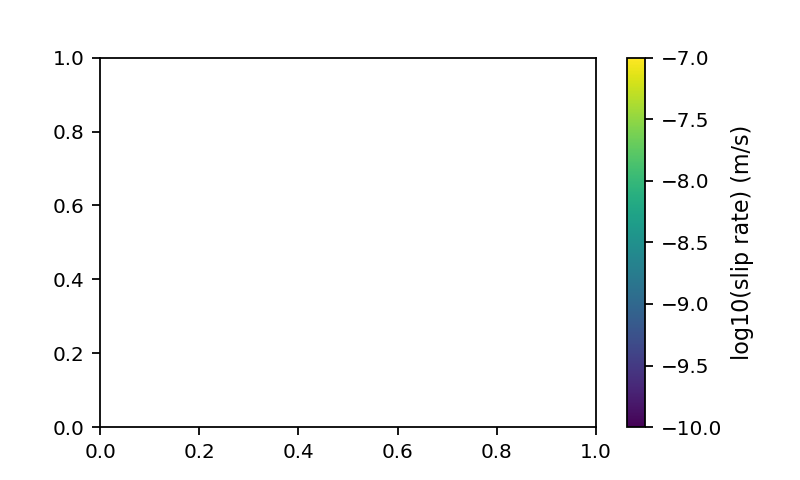

In [27]:
fig,ax0 = plt.subplots(ncols=1,nrows=1,figsize=(5,3))
# sc = ax0.tripcolor(triang,vcos[5,:], cmap='viridis',shading='flat',vmin=-10,vmax=-7)
cl = fig.colorbar(sc,ax=ax0,shrink=1.0)
cl.set_label('log10(slip rate) (m/s)')

plt.show()
outname = 'colorbar_sr.eps'
plt.savefig(outname,dpi=200,transparent=False)

<IPython.core.display.Javascript object>


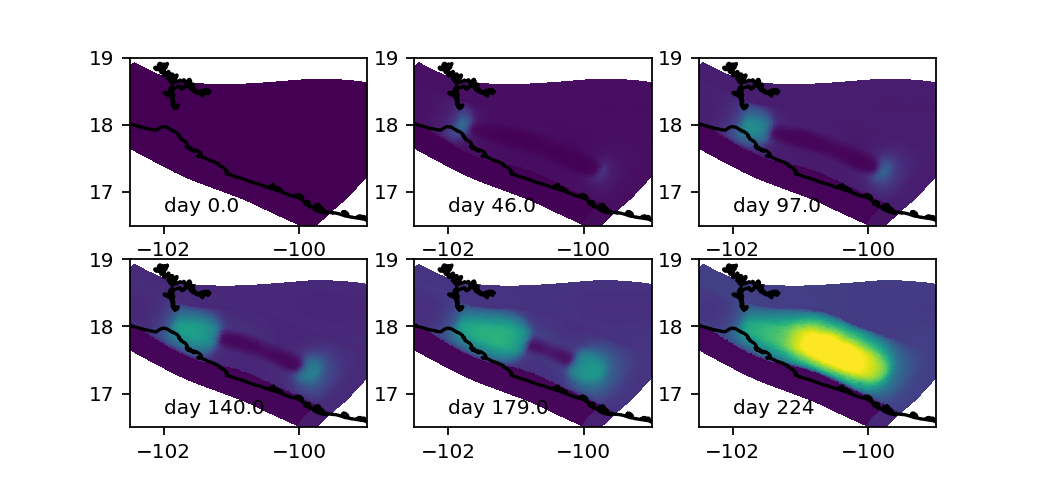

In [18]:
# snapshots of slip on the fault
pp = [580, 590, 600, 610, 620, 645]; # year 10
pp = [647, 700, 760, 820, 880, 966]; # year 14
pp = np.array([559, 559+33, 559+66, 559+99, 559+132, 559+165]);

slp = np.zeros((6,ncell))

for i in range(0,6):
    jj = pp[i]
    j0 = pp[0]
    slp[i,:] = 100*(fileslip[jj*ncell-ncell:jj*ncell]  -  fileslip[j0*ncell-ncell:j0*ncell])

    
fig,([ax0,ax1,ax2],[ax3,ax4,ax5]) = plt.subplots(nrows=2,ncols=3,figsize=(6.5,3))
    
sc = ax0.tripcolor(triang,slp[0,:], cmap='viridis',shading='flat',vmin=0,vmax=20)
# cl = fig.colorbar(sc,ax=ax0,shrink=0.75)
ax0.set(xlim=(-102.5, -99),ylim=(16.5,19))
ax0.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
ax0.text(-102, 16.7, 'day '+str(np.floor(dt[0])),fontsize=9)

sc = ax1.tripcolor(triang,slp[1,:], cmap='viridis',shading='flat',vmin=0,vmax=20)
# cl = fig.colorbar(sc,ax=ax1,shrink=0.75)
ax1.set(xlim=(-102.5, -99),ylim=(16.5,19))
ax1.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
ax1.text(-102, 16.7, 'day '+str(np.floor(dt[1])),fontsize=9)

sc = ax2.tripcolor(triang,slp[2,:], cmap='viridis',shading='flat',vmin=0,vmax=20)
# cl = fig.colorbar(sc,ax=ax1,shrink=0.75)
ax2.set(xlim=(-102.5, -99),ylim=(16.5,19))
ax2.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
ax2.text(-102, 16.7, 'day '+str(np.floor(dt[2])),fontsize=9)

sc = ax3.tripcolor(triang,slp[3,:], cmap='viridis',shading='flat',vmin=0,vmax=20)
# cl = fig.colorbar(sc,ax=ax1,shrink=0.75)
ax3.set(xlim=(-102.5, -99),ylim=(16.5,19))
ax3.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
ax3.text(-102, 16.7, 'day '+str(np.floor(dt[3])),fontsize=9)

sc = ax4.tripcolor(triang,slp[4,:], cmap='viridis',shading='flat',vmin=0,vmax=20)
# cl = fig.colorbar(sc,ax=ax1,shrink=0.75)
ax4.set(xlim=(-102.5, -99),ylim=(16.5,19))
ax4.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
ax4.text(-102, 16.7, 'day '+str(np.floor(dt[4])),fontsize=9)

sc = ax5.tripcolor(triang,slp[5,:], cmap='viridis',shading='flat',vmin=0,vmax=20)
# cl = fig.colorbar(sc,ax=ax1,shrink=0.75)
ax5.set(xlim=(-102.5, -99),ylim=(16.5,19))
ax5.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
# ax5.text(-102, 16.7, 'day '+str(np.floor(dt[5])),fontsize=9)
ax5.text(-102, 16.7, 'day '+str(224),fontsize=9)

plt.show()
outname = 'snapshot_slp.png'
plt.savefig(outname,dpi=200,transparent=False)

array([[-8.52340889, -9.08735085, -8.86477852, ..., -8.47139549,
        -8.47516441, -8.45279312],
       [-7.71259022, -7.15018272, -7.60841465, ..., -7.77788115,
        -7.75996304, -7.97335815],
       [-8.12814808, -9.86918068, -8.35099411, ..., -8.18427849,
        -8.17233086, -8.31186104],
       [-8.39065361, -7.66046333, -8.54635811, ..., -8.48532963,
        -8.47456741, -8.57642078],
       [-8.71818161, -9.31620121, -8.72824097, ..., -8.68136406,
        -8.69724846, -8.59933758],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [30]:
# new simulation with unlocked shallow fault
folder = '/import/deadlock-data/dli/Mexico/TriSSE/model_coarse/unlock/eq_h90_N25_T2/'
tfile = np.loadtxt(folder+ 't_sse-eq_h90_N25_T2.dat');

ncell = 90496
num = 16

# sfilename = folder + 'slipz1_tau'+str(num)+'.bin'
# sfile = open(sfilename,mode='rb')
# sfilecont = np.fromfile(sfile,dtype='<f4')
# sfile.close()

filename = folder + 'slipz1_sse'+str(num)+'.bin'
file = open(filename, mode='rb')# b is important -> binary
filecontent = np.fromfile(file,dtype='<f4')
file.close()

tsse = np.loadtxt(folder + 't_sse2.txt',delimiter=',')
t1 = tsse[num-15,0]
t2 = tsse[num-15,1]
tn = t2-t1+1
pp = [0,np.floor(tn/8),np.floor(tn/8)*2,np.floor(tn/8)*3,np.floor(tn/8)*4,np.floor(tn/8)*5,np.floor(tn/8)*6,np.floor(tn/8)*7,tn-2]

print(pp)

[0, 13.0, 26.0, 39.0, 52.0, 65.0, 78.0, 91.0, 102.0]


In [31]:
yrs = 365
dt = pp*yrs 
# duration = (tfile[pp[-1]] - tfile[pp[0]])*365 ;

vcos = np.zeros((9,ncell))
stress=np.zeros((9,ncell))

for i in range(0,9):
    jj = np.int(pp[i])
    print(jj)
    vcos[i,:] = filecontent[jj*ncell:jj*ncell+ncell]
#     stress[i,:]=sfilecont[jj*ncell:jj*ncell+ncell]

# stress = stress/10 # bar to MPa

0
13
26
39
52
65
78
91
102


<IPython.core.display.Javascript object>


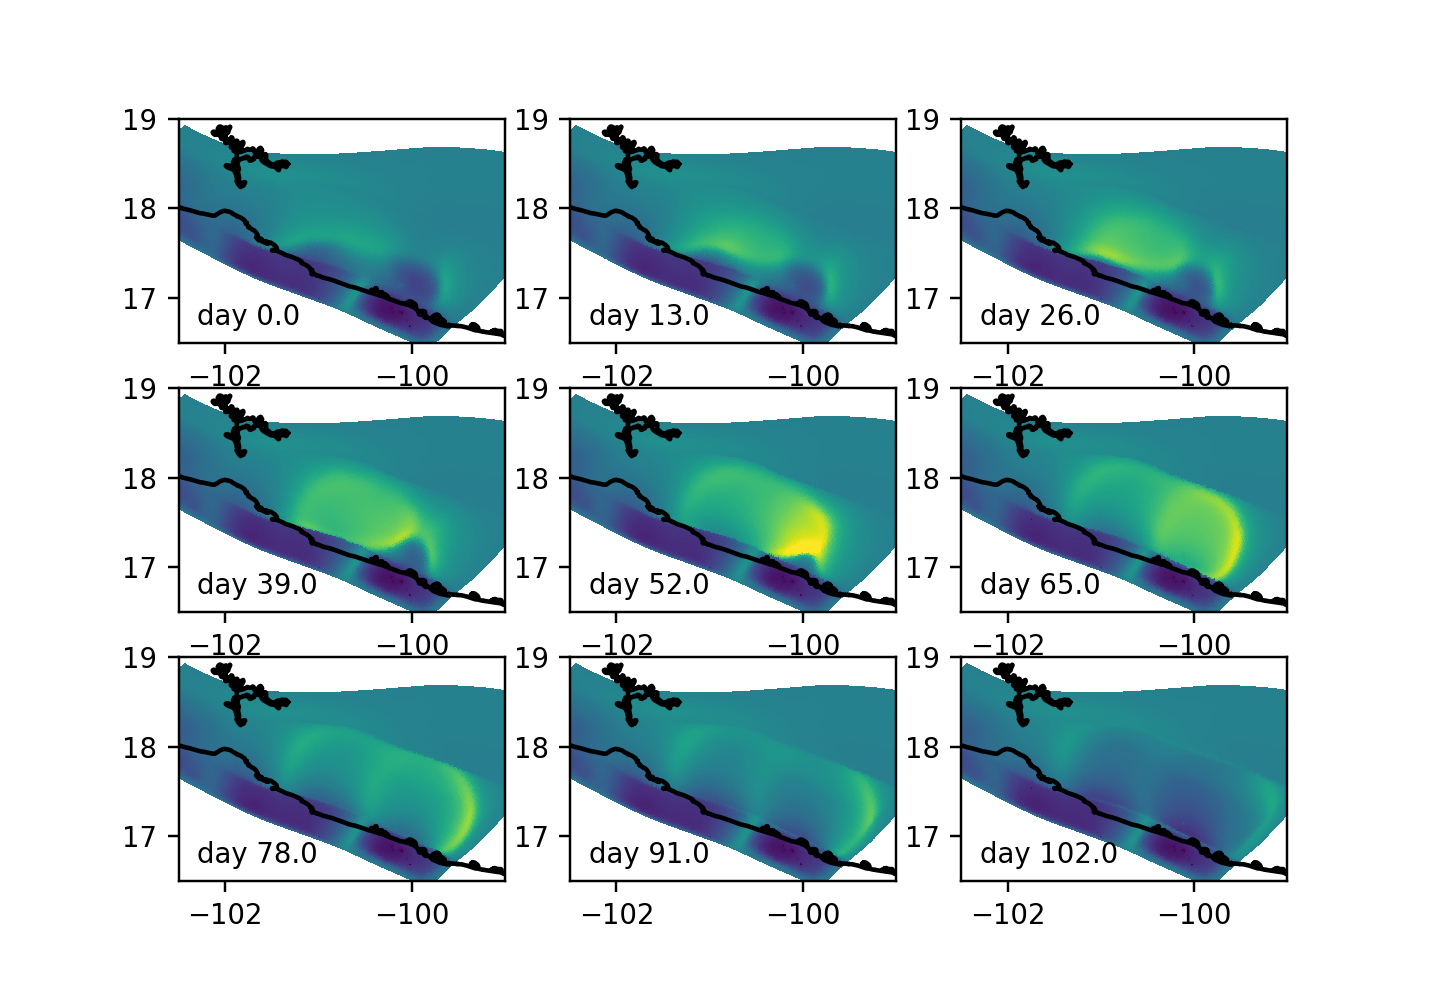

In [32]:
# plot snapshots of slip rate    
fig,([ax0,ax1,ax2],[ax3,ax4,ax5],[ax6,ax7,ax8]) = plt.subplots(nrows=3,ncols=3,figsize=(6.5,4.5))
    
sc = ax0.tripcolor(triang,vcos[0,:], cmap='viridis',shading='flat',vmin=-10,vmax=-7)
# cl = fig.colorbar(sc,ax=ax0,shrink=0.75)
ax0.set(xlim=(-102.5, -99),ylim=(16.5,19))
ax0.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
ax0.text(-102.3, 16.7, 'day '+str(np.floor(dt[0])),fontsize=9);

sc = ax1.tripcolor(triang,vcos[1,:], cmap='viridis',shading='flat',vmin=-10,vmax=-7)
# cl = fig.colorbar(sc,ax=ax1,shrink=0.75)
ax1.set(xlim=(-102.5, -99),ylim=(16.5,19))
ax1.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
ax1.text(-102.3, 16.7, 'day '+str(np.floor(dt[1])),fontsize=9);

sc = ax2.tripcolor(triang,vcos[2,:], cmap='viridis',shading='flat',vmin=-10,vmax=-7)
# cl = fig.colorbar(sc,ax=ax1,shrink=0.75)
ax2.set(xlim=(-102.5, -99),ylim=(16.5,19))
ax2.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
ax2.text(-102.3, 16.7, 'day '+str(np.floor(dt[2])),fontsize=9);

sc = ax3.tripcolor(triang,vcos[3,:], cmap='viridis',shading='flat',vmin=-10,vmax=-7)
ax3.set(xlim=(-102.5, -99),ylim=(16.5,19))
ax3.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
ax3.text(-102.3, 16.7, 'day '+str(np.floor(dt[3])),fontsize=9);

sc = ax4.tripcolor(triang,vcos[4,:], cmap='viridis',shading='flat',vmin=-10,vmax=-7)
ax4.set(xlim=(-102.5, -99),ylim=(16.5,19))
ax4.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
ax4.text(-102.3, 16.7, 'day '+str(np.floor(dt[4])),fontsize=9);

sc = ax5.tripcolor(triang,vcos[5,:], cmap='viridis',shading='flat',vmin=-10,vmax=-7)
ax5.set(xlim=(-102.5, -99),ylim=(16.5,19))
ax5.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
ax5.text(-102.3, 16.7, 'day '+str(np.floor(dt[5])),fontsize=9)

sc = ax6.tripcolor(triang,vcos[6,:], cmap='viridis',shading='flat',vmin=-10,vmax=-7)
ax6.set(xlim=(-102.5, -99),ylim=(16.5,19))
ax6.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
ax6.text(-102.3, 16.7, 'day '+str(np.floor(dt[6])),fontsize=9);

sc = ax7.tripcolor(triang,vcos[7,:], cmap='viridis',shading='flat',vmin=-10,vmax=-7)
ax7.set(xlim=(-102.5, -99),ylim=(16.5,19))
ax7.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
ax7.text(-102.3, 16.7, 'day '+str(np.floor(dt[7])),fontsize=9);

sc = ax8.tripcolor(triang,vcos[8,:], cmap='viridis',shading='flat',vmin=-10,vmax=-7)
ax8.set(xlim=(-102.5, -99),ylim=(16.5,19))
ax8.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
ax8.text(-102.3, 16.7, 'day '+str(np.floor(dt[8])),fontsize=9)

plt.show()
outname = folder + 'snap_sse'+str(num)+'_sr.png'
plt.savefig(outname,dpi=150,transparent=False)

<IPython.core.display.Javascript object>


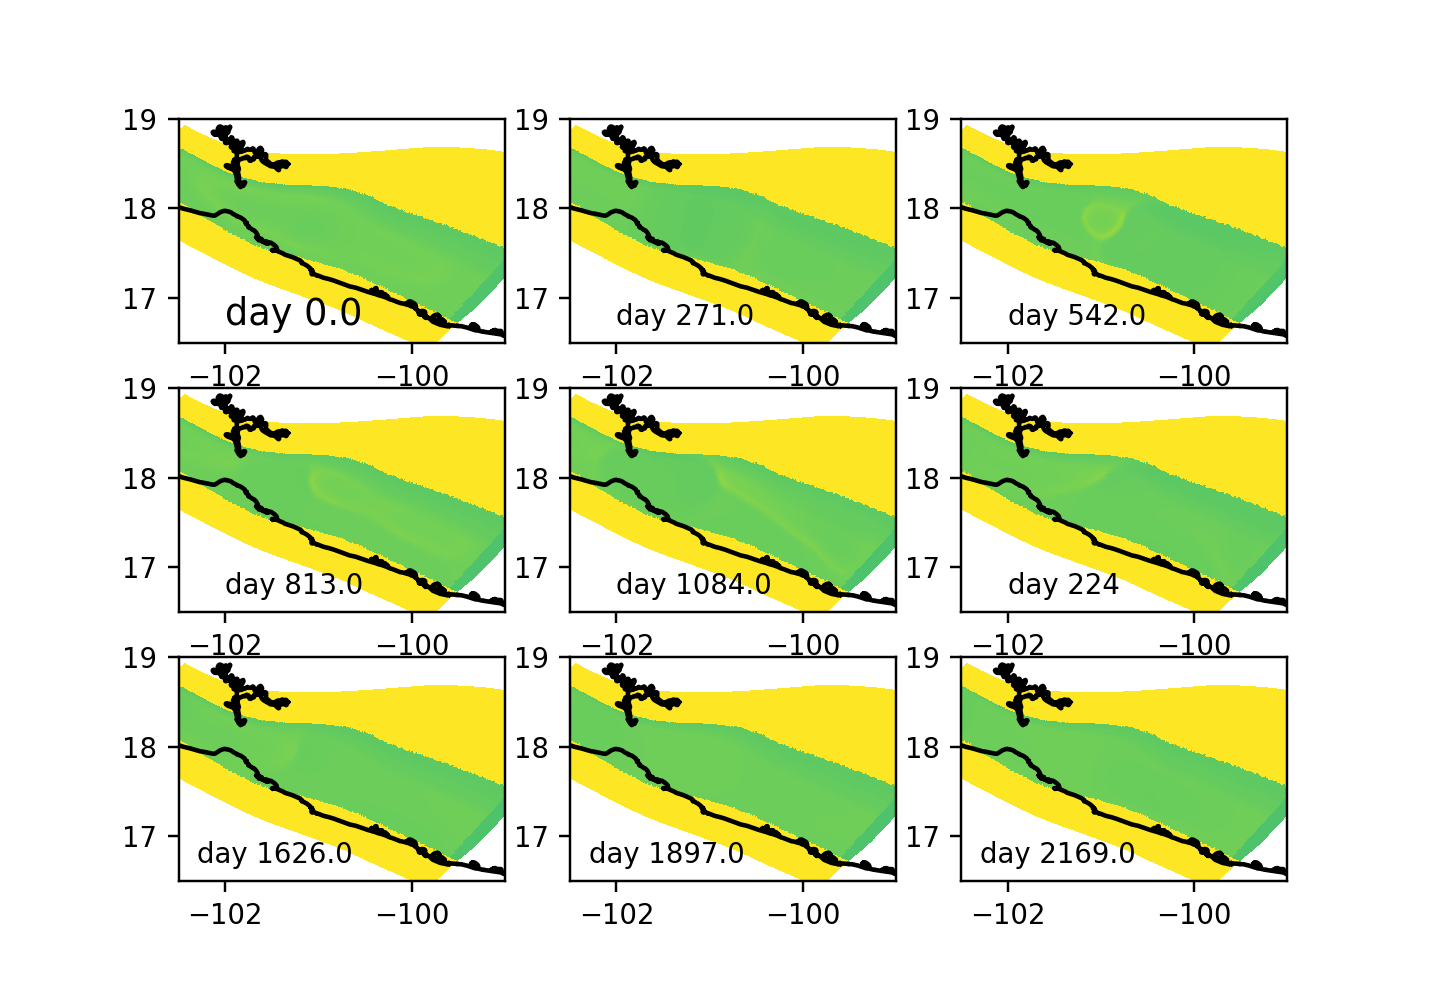

In [22]:
# plot snapshots of slip rate  
fig,([ax0,ax1,ax2],[ax3,ax4,ax5],[ax6,ax7,ax8]) = plt.subplots(nrows=3,ncols=3,figsize=(6.5,4.5))
    
sc = ax0.tripcolor(triang,stress[0,:], cmap='viridis',shading='flat',vmin=0,vmax=2.0)
# cl = fig.colorbar(sc,ax=ax0,shrink=0.75)
ax0.set(xlim=(-102.5, -99),ylim=(16.5,19))
ax0.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
ax0.text(-102, 16.7, 'day '+str(np.floor(dt[0])),fontsize=12);

sc = ax1.tripcolor(triang,stress[1,:], cmap='viridis',shading='flat',vmin=0,vmax=2.0)
# cl = fig.colorbar(sc,ax=ax1,shrink=0.75)
ax1.set(xlim=(-102.5, -99),ylim=(16.5,19))
ax1.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
ax1.text(-102, 16.7, 'day '+str(np.floor(dt[1])),fontsize=9);

sc = ax2.tripcolor(triang,stress[2,:], cmap='viridis',shading='flat',vmin=0,vmax=2.0)
# cl = fig.colorbar(sc,ax=ax1,shrink=0.75)
ax2.set(xlim=(-102.5, -99),ylim=(16.5,19))
ax2.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
ax2.text(-102, 16.7, 'day '+str(np.floor(dt[2])),fontsize=9);

sc = ax3.tripcolor(triang,stress[3,:], cmap='viridis',shading='flat',vmin=0,vmax=2.0)
# cl = fig.colorbar(sc,ax=ax1,shrink=0.75)
ax3.set(xlim=(-102.5, -99),ylim=(16.5,19))
ax3.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
ax3.text(-102, 16.7, 'day '+str(np.floor(dt[3])),fontsize=9);

sc = ax4.tripcolor(triang,stress[4,:], cmap='viridis',shading='flat',vmin=0,vmax=2.0)
# cl = fig.colorbar(sc,ax=ax1,shrink=0.75)
ax4.set(xlim=(-102.5, -99),ylim=(16.5,19))
ax4.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
ax4.text(-102, 16.7, 'day '+str(np.floor(dt[4])),fontsize=9);

sc = ax5.tripcolor(triang,stress[5,:], cmap='viridis',shading='flat',vmin=0,vmax=2.0)
# cl = fig.colorbar(sc,ax=ax1,shrink=0.75)
ax5.set(xlim=(-102.5, -99),ylim=(16.5,19))
ax5.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
# ax5.text(-102, 16.7, 'day '+str(np.floor(dt[5])),fontsize=9)
ax5.text(-102, 16.7, 'day '+str(224),fontsize=9)

sc = ax6.tripcolor(triang,stress[6,:], cmap='viridis',shading='flat',vmin=0,vmax=2.0)
ax6.set(xlim=(-102.5, -99),ylim=(16.5,19))
ax6.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
ax6.text(-102.3, 16.7, 'day '+str(np.floor(dt[6])),fontsize=9);

sc = ax7.tripcolor(triang,stress[7,:], cmap='viridis',shading='flat',vmin=0,vmax=2.0)
ax7.set(xlim=(-102.5, -99),ylim=(16.5,19))
ax7.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
ax7.text(-102.3, 16.7, 'day '+str(np.floor(dt[7])),fontsize=9);

sc = ax8.tripcolor(triang,stress[8,:], cmap='viridis',shading='flat',vmin=0,vmax=2.0)
ax8.set(xlim=(-102.5, -99),ylim=(16.5,19))
ax8.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
ax8.text(-102.3, 16.7, 'day '+str(np.floor(dt[8])),fontsize=9)


plt.show()
outname = folder + 'snap_sse'+str(num)+'_tau.png'
plt.savefig(outname,dpi=150,transparent=False)

In [43]:
print(np.max(stress[1,:]))
print(np.min(stress[1,:]))


32.056948852539065
-7.377973937988282
